In [1]:
import sys
if (path := "C:/Users/Tom/PycharmProjects/python-hvac") not in sys.path:
    sys.path.append(path)

In [2]:
from hvac import Quantity, print_doc_string
from hvac.charts import LineChart

Q_ = Quantity

# Chapter 3: Heat Gain through Windows
---

In this notebook it is demonstrated how windows are represented in the program, and how to determine the conduction heat gain and solar heat gain through a window. Windows can be equipped with an exterior and/or interior shading device (e.g. an overhang above a window, a recessed window, or shades on the interior side of a window). When modeling the thermal zone of a building, windows will be part of the exterior building elements that surround the thermal zone. So, it must also be possible to add windows to an exterior building element.

## Creating a Window

To model a window, we use the `Window` class. To create a `Window` object, we call the class method `create(...)`.

In [3]:
from hvac.cooling_load_calc import Window

In [4]:
print_doc_string(Window.create)

Creates a `Window` object.

Parameters
----------
name:
    Name to identify the `Window` object.
azimuth_angle:
    The azimuth angle of the window. South = 0°, West = +90° and 
    East = -90°.
slope_angle:
    Slope angle of the window. E.g., a vertical window has a slope angle
    of 90°.
width:
    Width of the window opening.
height:
    Height of the window opening.
weather_data:
    Instance of `WeatherData` class, containing the climatic design
    information.
props:
    See class `WindowThermalProperties`. The thermal and solar properties
    of the window.
F_rad: default 0.46
    Radiative fraction of conduction heat gain through window to the 
    interior thermal mass of the space. (see ASHRAE Fundamentals 2017, 
    chapter 18, table 14).
ext_shading: default None
    E.g. an overhang or recessed window. See: class `ExternalShadingDevice`.
    If a window has an external shading device, or if the window is
    recessed, part of the window may be shaded depending on the p

First of all, we see from the docstring that to create a window, we need the `WeatherData` object again that we also needed to create an exterior building element (see notebook no. 2). So, first we will create the `Location` instance again, that we then pass to the factory method of the `WeatherData` class.  

In [5]:
from hvac.sun import Location, ClimateType, ReferenceDates
from hvac.cooling_load_calc import WeatherData

In [6]:
location = Location(
    fi=Q_(51.183, 'deg'),
    L_loc=Q_(3.8, 'deg'),
    altitude=Q_(8, 'm'),
    climate_type=ClimateType.MID_LATITUDE_SUMMER,
    timezone='Etc/GMT-1'
)

In [7]:
weather_data = WeatherData.create_from_climatic_design_data(
    location=location,
    date=ReferenceDates.get_date_for('Jun'),  # this returns the "design day" for June
    T_db_des=Q_(24.2, 'degC'),
    T_db_rng=Q_(11.8, 'K'),
    T_wb_mc=Q_(18.0, 'degC'),
    T_wb_rng=Q_(5.6, 'K')
)

From the docstring, we also see that we need a `WindowsThermalProperties` object. This object contains the thermal properties of the window. 

### Window Thermal Properties

In [8]:
from hvac.cooling_load_calc import WindowThermalProperties

In [9]:
print_doc_string(WindowThermalProperties.__init__)

Creates a `WindowThermalProperties` object.

Parameters
----------
ID:
    Identifier for the type of window.
U:
    Overall U value of the entire window, including edge effects and
    window frame (see ASHRAE Fundamentals 2017, Ch. 15, Table 4).
SHGC_cog_dir:
    Dictionary of which the keys are solar incidence angles in degrees
    and the values the corresponding SHGC values (see ASHRAE
    Fundamentals 2017, Ch. 15, Table 10).
SHGC_cog_dif:
    The SHGC for diffuse solar radiation (see ASHRAE Fundamentals 2017,
    Ch. 15, Table 10).
SHGC_wnd:
    The SHGC of the entire window at normal incidence (see ASHRAE
    Fundamentals 2017, Ch. 15, Table 10).

Parameter Types & Defaults
--------------------------
ID: str
U: pint.Quantity
SHGC_cog_dir: dict[float, float]
SHGC_cog_dif: float
SHGC_wnd: float


The methods and the data these methods need to calculate the conduction heat gain and the solar heat gain of windows are explained in ASHRAE Fundamentals Handbook 2017, Chapter 15. Here we will define the window thermal properties for a vertical window with uncoated double glazing (ASHRAE 2017, Chapter 15, Table 10, ID 5a) in an operable frame made of wood or vinyl (ASHRAE 2017, Chapter 15, Table 4, ID 5).

In [10]:
wnd_props = WindowThermalProperties(
    ID='window-5a-operable-wood/vinyl',
    U=Q_(2.86, 'W / (m ** 2 * K)'),
    SHGC_cog_dir={
        0.00: 0.76,
        40.0: 0.74,
        50.0: 0.71,
        60.0: 0.64,
        70.0: 0.50,
        80.0: 0.26
    },
    SHGC_cog_dif=0.66,
    SHGC_wnd=0.62
)

Like construction assemblies, `WindowThermalProperties` objects can be "shelved" for later reuse. For this, we assign the file path to the shelf to class attribute `db_path`. Next, we can call method `save()` on our object to save it on the shelf.

In [11]:
WindowThermalProperties.db_path = "./window_shelf/windows"
wnd_props.save()

Now, we can create our `Window` object:

In [12]:
window = Window.create(
    name='window',
    azimuth_angle=Q_(0, 'deg'),  # oriented South
    slope_angle=Q_(90, 'deg'),  # vertical window
    width=Q_(2, 'm'),
    height=Q_(2, 'm'),
    weather_data=weather_data,
    props=wnd_props,
    F_rad=0.33
)

Parameter `F_rad` is the radiative fraction which is only applicable to the conduction heat gain through the window. According to table 14 in chapter 18 of ASHRAE Fundamentals 2017, if the SHGC of the entire window is greater than 0.5, a value for `F_rad` of 0.33 is recommended. 

## Conduction Heat Gain Through the Window

Method `conduction_heat_gain(T_za)` returns the hourly values of the conduction heat gain through the window on the selected design day, which we have specified when instantiating the `WeatherData` object. The method returns the global conduction heat gain through the window, and also its convective and radiative fractions, according to the parameter `F_rad` that we've assigned when instantiating the window. We can display the values in a Pandas `DataFrame` object and also plot them on a line chart.

In [13]:
Q_cnd, Q_cnd_cv, Q_cnd_rad = window.conduction_heat_gain(T_za=Q_(22, 'degC'))

Parameter `T_za` is the fixed zone-air temperature on the interior side of the window.

In [14]:
import pandas as pd

df = pd.DataFrame({
    'Q_cnd': Q_cnd.to('W').m,
    'Q_cnd_cv': Q_cnd_cv.to('W').m,
    'Q_cnd_rad': Q_cnd_rad.to('W').m
})
df

,Q_cnd,Q_cnd_cv,Q_cnd_rad
0,-85.52544,-57.302045,-28.223395
1,-93.62496,-62.728723,-30.896237
2,-99.02464,-66.346509,-32.678131
3,-103.07440,-69.059848,-34.014552
4,-107.12416,-71.773187,-35.350973
5,-109.82400,-73.582080,-36.241920
6,-107.12416,-71.773187,-35.350973
7,-97.67472,-65.442062,-32.232658
8,-74.72608,-50.066474,-24.659606
9,-49.07760,-32.881992,-16.195608


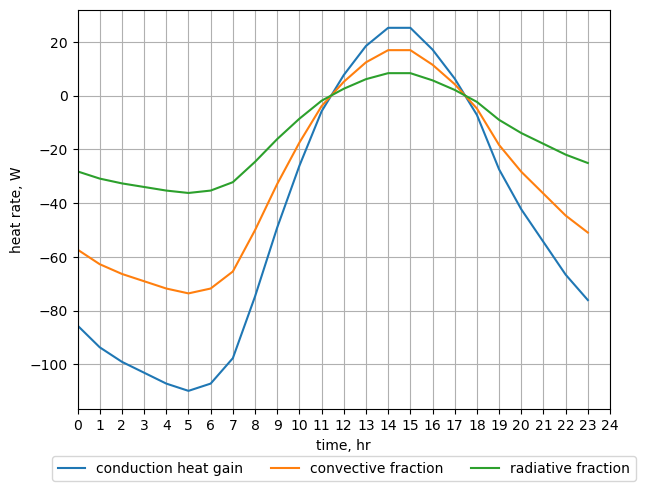

In [15]:
chart = LineChart()
chart.add_xy_data(
    label='conduction heat gain',
    x1_values=df.index,
    y1_values=df['Q_cnd']
)
chart.add_xy_data(
    label='convective fraction',
    x1_values=df.index,
    y1_values=df['Q_cnd_cv']
)
chart.add_xy_data(
    label='radiative fraction',
    x1_values=df.index,
    y1_values=df['Q_cnd_rad']
)
chart.add_legend(columns=3)
chart.x1.add_title('time, hr')
chart.y1.add_title('heat rate, W')
chart.x1.scale(0, 25, 1)
chart.show()

Note that negative values indicate a heat loss from the thermal zone, rather than being a heat gain to the zone.

## Solar Heat Gain Through the Window

The solar heat gain through the window can be calculated at any time time moment of the selected design day. To calculate the solar heat gain on a specific time moment `t`, we call method `solar_heat_gain(t)`. The method returns the global solar heat gain through the window, its convective fraction, and its radiative fraction.

> **Note**<br>
It should be noted that the time `t` passed in the call to `solar_heat_gain(t)` is a decimal value; it is the time of the day passed since solar midnight (hour 0). It should also be noted that all calculations in this package are done in solar time, not clock time. To convert from solar seconds to clock time and vice versa, one can use the utility functions from module `time_conversion`. In the code block below the conversion is done from solar decimal time to clock time, needing the longitude and timezone of the geographical location. The function `convert_to_clock_time` returns a tuple of two Python `datetime` objects. The first element is the clock time, the second element is the solar time (as datetime object instead of a decimal time value).  

In [16]:
from datetime import datetime
from hvac.cooling_load_calc.time_conversion import convert_to_clock_time

solar_hours_dec = [Q_(hr, 'hr') for hr in range(24)]

clock_times = [
    convert_to_clock_time(
        t_sol_sec=t_sol.to('s').magnitude,
        date=weather_data.date,
        L_loc=weather_data.location.L_loc,
        tz_loc="Europe/Brussels"
    ) for t_sol in solar_hours_dec
]

for t_sol, t_clock in zip(solar_hours_dec, clock_times):
    print(f"{t_sol:~P.0f} -> {t_clock[0].time().strftime("%H:%M:%S")}")

0 h -> 01:43:59
1 h -> 02:43:59
2 h -> 03:43:59
3 h -> 04:43:59
4 h -> 05:43:59
5 h -> 06:43:59
6 h -> 07:43:59
7 h -> 08:43:59
8 h -> 09:43:59
9 h -> 10:43:59
10 h -> 11:43:59
11 h -> 12:43:59
12 h -> 13:43:59
13 h -> 14:43:59
14 h -> 15:43:59
15 h -> 16:43:59
16 h -> 17:43:59
17 h -> 18:43:59
18 h -> 19:43:59
19 h -> 20:43:59
20 h -> 21:43:59
21 h -> 22:43:59
22 h -> 23:43:59
23 h -> 00:43:59


So, when we look at the solar heat gain through the window at solar noon (12 h), the clock will actually show 13:43:59.

In the code block below the solar heat gain through the window is calculated at each hour of the "solar day" and the results are displayed in a Pandas `DataFrame`. Notice that the convective fraction of the solar heat gain is zero each time (which means that all solar heat gain is transferred to the interior mass of the thermal zone in the building).

In [17]:
Q_sol, Q_sol_cv, Q_sol_rad = zip(*[window.solar_heat_gain(t) for t in solar_hours_dec])
Q_sol = Quantity.from_sequence(Q_sol)
Q_sol_cv = Quantity.from_sequence(Q_sol_cv)
Q_sol_rad = Quantity.from_sequence(Q_sol_rad)

df1 = pd.DataFrame({
    'Q_sol': Q_sol.to('W').m,
    'Q_sol_cv': Q_sol_cv.to('W').m,
    'Q_sol_rad': Q_sol_rad.to('W').m
})
df1

,Q_sol,Q_sol_cv,Q_sol_rad
0,0.000000,0.0,0.000000
1,0.000000,0.0,0.000000
2,0.000000,0.0,0.000000
3,9.019691,0.0,9.019691
4,50.484388,0.0,50.484388
5,141.697605,0.0,141.697605
6,223.937595,0.0,223.937595
7,294.313368,0.0,294.313368
8,417.510013,0.0,417.510013
9,613.004450,0.0,613.004450


We can also plot these results on a line chart:

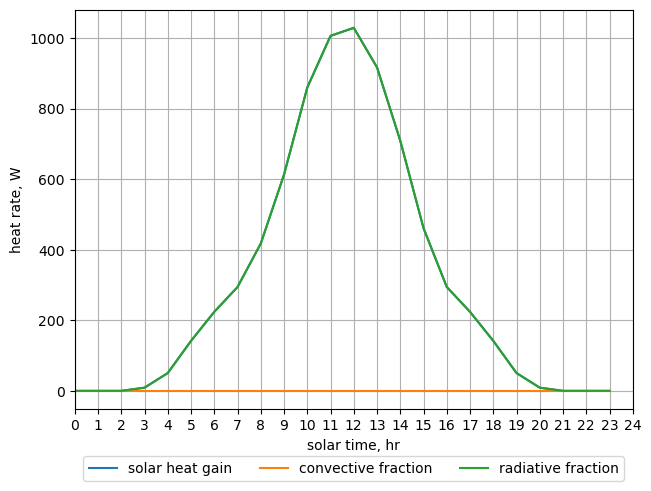

In [18]:
chart = LineChart()
chart.add_xy_data(
    label='solar heat gain',
    x1_values=df1.index,
    y1_values=df1['Q_sol']
)
chart.add_xy_data(
    label='convective fraction',
    x1_values=df1.index,
    y1_values=df1['Q_sol_cv']
)
chart.add_xy_data(
    label='radiative fraction',
    x1_values=df1.index,
    y1_values=df1['Q_sol_rad']
)
chart.add_legend(columns=3)
chart.x1.add_title('solar time, hr')
chart.y1.add_title('heat rate, W')
chart.x1.scale(0, 25, 1)
chart.show()

## Creating a Window with an Exterior Shading Device

To reduce the solar heat gain through the window, we could decide to add a horizontal overhang above the window.

In [19]:
from hvac.cooling_load_calc import ExteriorShadingDevice

In [20]:
print_doc_string(ExteriorShadingDevice)

Represents an overhang above a window or a recessed window.

Parameters
----------
vert_proj_dist: default 0 m
    Protrusion distance of the vertical surfaces of the exterior shading 
    device.
hor_proj_dist: default 0 m
    Protrusion distance of the exterior shading device's horizontal surface 
    above the window.
hor_offset : default 0 m
    Distance between the upright window edges and the vertical sides of the 
    exterior shading device.
vert_offset : default 0 m
    Distance between the window's horizontal upper edge and the underside of
    the exterior shading device's horizontal surface.

Parameter Types & Defaults
--------------------------
vert_proj_dist: pint.Quantity = <Quantity(0, 'meter')>
hor_proj_dist: pint.Quantity = <Quantity(0, 'meter')>
hor_offset: pint.Quantity = <Quantity(0, 'meter')>
vert_offset: pint.Quantity = <Quantity(0, 'meter')>


To define the horizontal overhang above the window, we need to specify how far the overhang extends from the wall and the vertical distance between its underside and the upper edge of the window.

In [21]:
overhang = ExteriorShadingDevice(
    hor_proj_dist=Q_(80, 'cm'),
    vert_offset=Q_(20, 'cm')
)

window_with_overhang = Window.create(
    name='window',
    azimuth_angle=Q_(0, 'deg'),  # oriented South
    slope_angle=Q_(90, 'deg'),  # vertical window
    width=Q_(2, 'm'),
    height=Q_(2, 'm'),
    weather_data=weather_data,
    props=wnd_props,
    F_rad=0.33,
    ext_shading=overhang
)

To see the effect of the overhang, we calculate the solar heat gain through the window with the overhang and we will compare it graphically with the window without the overhang.

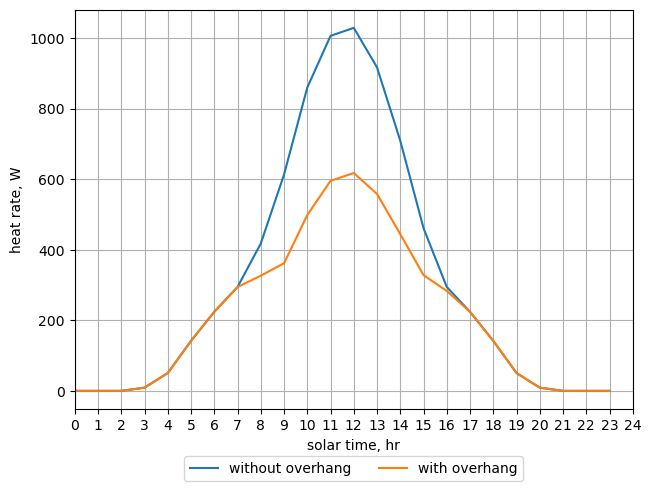

In [22]:
Q_sol, Q_sol_cv, Q_sol_rad = zip(*[window_with_overhang.solar_heat_gain(t) for t in solar_hours_dec])
Q_sol = Quantity.from_sequence(Q_sol)
Q_sol_cv = Quantity.from_sequence(Q_sol_cv)
Q_sol_rad = Quantity.from_sequence(Q_sol_rad)

df2 = pd.DataFrame({
    'Q_sol': Q_sol.to('W').m,
    'Q_sol_cv': Q_sol_cv.to('W').m,
    'Q_sol_rad': Q_sol_rad.to('W').m
})

chart = LineChart()
chart.add_xy_data(
    label='without overhang',
    x1_values=df1.index,
    y1_values=df1['Q_sol']
)
chart.add_xy_data(
    label='with overhang',
    x1_values=df1.index,
    y1_values=df2['Q_sol']
)
chart.add_legend(columns=2)
chart.x1.add_title('solar time, hr')
chart.y1.add_title('heat rate, W')
chart.x1.scale(0, 25, 1)
chart.show()

## Creating a Window with an Interior Shading Device

In [23]:
from hvac.cooling_load_calc import InteriorShadingDevice

In [24]:
print_doc_string(InteriorShadingDevice)

Represents louvered shades, roller shades, draperies or insect screens
(see ASHRAE Fundamentals 2017, Ch. 15, §5.2 and tables 14A to 14G).

Parameters
----------
IAC_dif:
    Interior attenuation coefficient for diffuse solar radiation.
F_rad:
    Radiative fraction of solar heat gain through window in combination with
    interior shading device.
IAC_0 : default None
    Interior attenuation coefficient for direct solar radiation at normal
    incidence angle (0°).
IAC_60: default None
    Interior attenuation coefficient for direct solar radiation at an
    incidence angle of 60°.
louver_orient: default 'horizontal'
    Sets the orientation of the louvers: either 'horizontal' or 'vertical'.

Notes
-----
Only for louvered shades, three IAC values are being considered (IAC_0,
IAC_60, and IAC_dif). In other cases there is only one IAC value, which
applies both to direct and diffuse solar radiation. In these cases it
suffices to provide only a value to parameter `IAC_dif`.

Parameter Typ

We will define a slat-type sunshade with horizontally oriented louvers installed on the indoor side of our window having uncoated double glazing (ID 5a). The shade material has a reflectance of 0.80 and the shades are installed in the closed position. The IAC-values and radiant fraction are taken from table 14B in Chapter 15 of ASHRAE Fundamentals 2017.

In [25]:
louvered_shade = InteriorShadingDevice(
    IAC_dif=0.55,
    F_rad=0.46,
    IAC_0=0.47,
    IAC_60=0.45
)

window_with_shade = Window.create(
    name='window',
    azimuth_angle=Q_(0, 'deg'),  # oriented South
    slope_angle=Q_(90, 'deg'),  # vertical window
    width=Q_(2, 'm'),
    height=Q_(2, 'm'),
    weather_data=weather_data,
    props=wnd_props,
    F_rad=0.33,
    int_shading=louvered_shade
)

Now we can compare the effect of the louvered shades on the solar heat gain through the window with the effect of the exterior overhang and also with the solar heat gain through the window having no shading device.

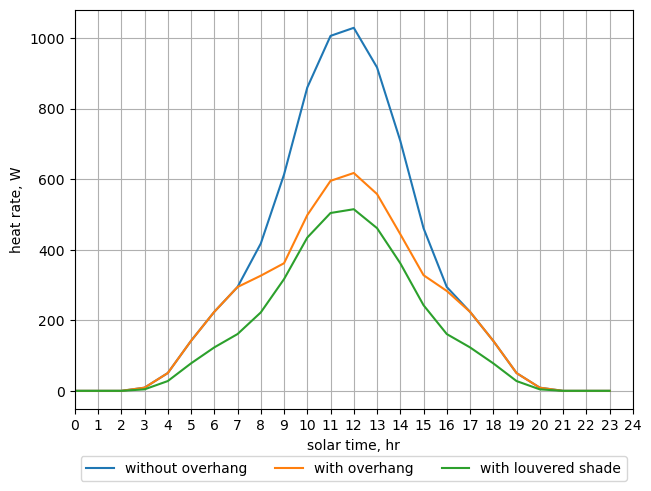

In [26]:
Q_sol, Q_sol_cv, Q_sol_rad = zip(*[window_with_shade.solar_heat_gain(t) for t in solar_hours_dec])
Q_sol = Quantity.from_sequence(Q_sol)
Q_sol_cv = Quantity.from_sequence(Q_sol_cv)
Q_sol_rad = Quantity.from_sequence(Q_sol_rad)

df3 = pd.DataFrame({
    'Q_sol': Q_sol.to('W').m,
    'Q_sol_cv': Q_sol_cv.to('W').m,
    'Q_sol_rad': Q_sol_rad.to('W').m
})

chart = LineChart()
chart.add_xy_data(
    label='without overhang',
    x1_values=df1.index,
    y1_values=df1['Q_sol']
)
chart.add_xy_data(
    label='with overhang',
    x1_values=df2.index,
    y1_values=df2['Q_sol']
)
chart.add_xy_data(
    label='with louvered shade',
    x1_values=df3.index,
    y1_values=df3['Q_sol']
)
chart.add_legend(columns=3)
chart.x1.add_title('solar time, hr')
chart.y1.add_title('heat rate, W')
chart.x1.scale(0, 25, 1)
chart.show()

## Adding a Window to an Exterior Building Element

An object of class `ExteriorBuildingElement` has a method `add_window(...)` to add a window to an exterior building element.

In [27]:
from hvac.cooling_load_calc import ExteriorBuildingElement

In [28]:
print_doc_string(ExteriorBuildingElement.add_window)

Adds a window to the exterior building element.

Parameters
----------
name:
    Identifies the window. `Window` objects are hold in a dictionary 
    `windows`. The name of the window is used as the key in this 
    dictionary.
width:
    The width of the window.
height:
    The height of the window.
props:
    A `WindowsThermalProperties` object that holds the thermal
    and solar properties of the window.
F_rad: default 0.46
    Radiative fraction of solar heat gain through window to the interior
    thermal mass of the space. (see ASHRAE Fundamentals 2017, chapter 18,
    table 14).
ext_shading: default None
    E.g. an overhang or recessed window. See: class `ExternalShadingDevice`.
    If a window has an external shading device, or if the window is
    recessed, part of the window may be shaded depending on the position
    of the sun during the day.
int_shading: default None
    E.g. a louvered shade, roller shade, drapery, or insect screen.
    See: class `InteriorShadingDevic

Let us re-create the exterior vertical wall from the previous notebook no. 2 and then add the window to this wall with both the overhang and the louvred shades. The window retrieves the properties that it shares with the exterior wall (azimuth angle, slope angle, and weather data) from this exterior wall. 

In [32]:
from hvac.cooling_load_calc import ConstructionAssembly

ConstructionAssembly.db_path = "./construction_shelf/assemblies"
constr_assem = ConstructionAssembly.load('exterior-wall')

ext_wall = ExteriorBuildingElement.create(
    name='exterior-wall',
    gross_area=Q_(10, 'm') * Q_(3, 'm'),  # surface area of the wall
    constr_assem=constr_assem,
    weather_data=weather_data,
    azimuth_angle=Q_(0, 'deg'),  # oriented to the south
    slope_angle=Q_(90, 'deg')   # vertical wall
)

print(
    f"Before adding the window:",
    f"- gross area of the exterior wall = {ext_wall.gross_area.to('m**2'):~P.1f}",
    f"- net area of the exterior wall = {ext_wall.net_area.to('m**2'):~P.1f}",
    sep='\n'
)

window_in_wall = ext_wall.add_window(
    name='window_1',
    width=Q_(2, 'm'),
    height=Q_(2, 'm'),
    props=wnd_props,
    F_rad=0.33,
    ext_shading=overhang,
    int_shading=louvered_shade
)

print(
    f"After adding the window:",
    f"- gross area of the exterior wall = {ext_wall.gross_area.to('m**2'):~P.1f}",
    f"- net area of the exterior wall = {ext_wall.net_area.to('m**2'):~P.1f}",
    sep='\n'
)

Before adding the window:
- gross area of the exterior wall = 30.0 m²
- net area of the exterior wall = 30.0 m²
After adding the window:
- gross area of the exterior wall = 30.0 m²
- net area of the exterior wall = 26.0 m²


Windows added to an exterior building element are held in a dictionary `windows`. The keys of the dictionary are the names of the windows. The names of the windows which are added to the same exterior building element must therefore be unique.

In [33]:
print(ext_wall.windows)

{'window_1': <hvac.cooling_load_calc.building.fenestration.Window object at 0x0000022BFC63A930>}


> **Note**<br>
Besides adding windows to an exterior building element, we can also add opaque exterior doors by calling method `add_door(...)`.

In [34]:
print_doc_string(ExteriorBuildingElement.add_door)

Adds a door to the exterior building element.

An exterior door is also represented by the `ExteriorBuildingElement` 
class.

Parameters
----------
name:
    Name to identify the door.
width:
    Width of the door.
height:
    Height of the door. 
constr_assem:
    Construction assembly the door is made of.
surface_color: optional
    Either a 'dark' (default) or 'light' colored surface.
R_surf: optional
    Thermal resistance of the exterior surface film.
a_surf: optional
    Absorption factor of the exterior surface.
rho_g: Quantity, default 0.2 frac
    Ground reflectance.
sky_model: str, {'anisotropic.hdkr, 'isotropic'}, optional
    Sky model to be used for calculating the irradiation on the tilted
    surface. By default, the anisotropic sky model according to Perez
    is used.
F_rad: default 0.46
    Radiative fraction of the conduction heat gain through the door
    building element, taken up by the interior thermal mass of the
    space (see ASHRAE Fundamentals 2017, chapter 

Exterior doors added to an exterior building element are held in a dictionary `doors` of the `ExteriorBuildingElement` class.